## Trabalho 1 - Reconhecimento de Padrões
Aluno: Luis Felipe Carneiro de Souza

Matrícula: 535049

> Os códigos deste trabalho foram desenvolvido com bases no material em MATLAB/OCTAVE disponibilizado pelo professor

importação de bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import time
from scipy.spatial.distance import minkowski
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

Lendo o conjunto de dados como um DataFrame

In [29]:
conjunto = pd.read_csv('column_3C.dat', header=None, sep='\s+')
#print(conjunto.info)
conjunto = conjunto.sample(frac=1)
conjunto = conjunto.iloc[:200, :] # Pegando os primeiros 60 elementos para os códigos executarem mais rápido
conjunto.head()

,0,1,2,3,4,5,6
93,58.10,14.84,79.65,43.26,113.59,50.24,SL
54,41.17,17.32,33.47,23.85,116.38,-9.57,DH
151,48.03,3.97,58.34,44.06,125.35,35.00,SL
290,36.42,13.88,20.24,22.54,126.08,0.18,NO
143,60.63,20.60,64.54,40.03,117.23,104.86,SL


Separando o conjunto de dados entre variáveis de entrada e variáveis resposta

In [30]:
x = conjunto.iloc[:, 0:-1]
y = conjunto.iloc[:, -1]

In [31]:
x = conjunto.iloc[:, 0:-1]
y = conjunto.iloc[:, -1]

x_n = normalize(x, norm='l2', axis=1)
x = pd.DataFrame(x_n, index=x.index, columns=x.columns)

Dicionário de proporção de separação entre conjunto de treino e teste

In [19]:
sep = {'20/80': {'train': 0.2, 'test': 0.8},
       '30/70': {'train': 0.3, 'test': 0.7},
       '50/50': {'train': 0.5, 'test': 0.5},
       '70/30': {'train': 0.7, 'test': 0.3},
       '80/20': {'train': 0.8, 'test': 0.2}}

### Classificador Vizinho Mais Próximo (distância de Minkowski de ordens m ∈ {0,5; 2/3; 1; 3/2; 2; 5/2})

In [28]:
resultados_knn = {}
C = conjunto.iloc[:, -1].unique()
for s in sep.keys():
    resultados_knn[s] = {}

    N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

    for m in [0.5, 2/3, 1, 3/2, 2, 5/2]: # diferentes ordens da distância de Minkowski

        #print(f'\n\nSeparação {s} e distância de Minkowski de ordem {m}\n')

        acc_por_classe_lists = {classe: [] for classe in C}

        Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
        inicio = time.perf_counter()

        for rep in range(100): # 100 rodadas de treino
            #print(f'Rodada de número {rep + 1}')

            x = x.sample(frac=1) # embaralha as amostras
            y = y.loc[x.index] # embaralha as classes

            # conjunto de treino
            x_trn, y_trn = x.iloc[:N_trn, :], y.iloc[:N_trn]  
            
            # conjunto de teste
            x_tst, y_tst = x.iloc[N_trn:, :], y.iloc[N_trn:]

            class_hits = {classe: 0 for classe in C}
            class_totals = {classe: 0 for classe in C}

            # loop que itera sobre o conjunto de teste
            acerto = 0 # contador de acertos
            for i in range(len(x_tst)):
                x_new = np.array(x_tst.iloc[i, :]) # nova amostra a ser classificada
                y_true = y_tst.iloc[i] # classe da nova amostra

                dist_array = []
                for j in range(len(x_trn)):
                    dist_array.append(minkowski(x_new, np.array(x_trn.iloc[j, :]), p=m)) # distância de Minkowski de ordem m
                
                j_min = np.argmin(dist_array) # índice do menor valor de distância

                class_totals[y_true] += 1

                if y_trn.iloc[j_min] == y_true: # verifica se a classificação foi correta
                    acerto += 1
                    class_hits[y_true] += 1
        
            Pacerto.append(acerto / len(x_tst)) # calcula a porcentagem de acertos

            for classe in C:
                total = class_totals[classe]
                hits = class_hits[classe]

                if total > 0:
                    acc_da_classe_nesta_rodada = hits / total
                else:
                    acc_da_classe_nesta_rodada = np.nan

                acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)


        fim = time.perf_counter()

        stats_por_classe = {}
        for classe, lista_de_acuracias in acc_por_classe_lists.items():
            stats_por_classe[classe]= {
                'media': np.nanmean(lista_de_acuracias),
                'desvio': np.nanstd(lista_de_acuracias),
                'mediana': np.nanmedian(lista_de_acuracias),
                'minimo': np.nanmin(lista_de_acuracias),
                'maximo': np.nanmax(lista_de_acuracias),
            }

        resultados_knn[s][m] = {'media': np.mean(Pacerto),
                           'desvio': np.std(Pacerto),
                           'mediana': np.median(Pacerto),
                           'minimo': np.min(Pacerto),
                           'maximo': np.max(Pacerto),
                           'stats_por_classe': stats_por_classe,
                           'tempo': fim - inicio}
resultados_knn

{'20/80': {0.5: {'media': np.float64(0.6749999999999998),
   'desvio': np.float64(0.06997023176561111),
   'mediana': np.float64(0.6666666666666666),
   'minimo': np.float64(0.4583333333333333),
   'maximo': np.float64(0.8333333333333334),
   'stats_por_classe': {'NO': {'media': np.float64(0.38166666666666665),
     'desvio': np.float64(0.352148169572601),
     'mediana': np.float64(0.29166666666666663),
     'minimo': np.float64(0.0),
     'maximo': np.float64(1.0)},
    'SL': {'media': np.float64(0.8851849816849818),
     'desvio': np.float64(0.10247403516061805),
     'mediana': np.float64(0.8958333333333333),
     'minimo': np.float64(0.6),
     'maximo': np.float64(1.0)},
    'DH': {'media': np.float64(0.47100000000000003),
     'desvio': np.float64(0.344783506952793),
     'mediana': np.float64(0.5),
     'minimo': np.float64(0.0),
     'maximo': np.float64(1.0)}},
   'tempo': 2.0521455999696627},
  0.6666666666666666: {'media': np.float64(0.6816666666666665),
   'desvio': np.flo

### Classificador Distância Mínima ao Centróide

In [32]:
resultados_centroide = {}
C = conjunto.iloc[:, -1].unique()
for s in sep.keys():

    #print(f'\n\nSeparação {s}')

    N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

    acc_por_classe_lists = {classe: [] for classe in C}

    Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
    inicio = time.perf_counter()

    for rep in range(100): # 100 rodadas de treino
        #print(f'Rodada de número {rep + 1}')

        x = x.sample(frac=1)
        y = y.loc[x.index]
        
        # conjunto de treino
        x_trn, y_trn = x.iloc[:N_trn, :], y.iloc[:N_trn]  
        
        # conjunto de teste
        x_tst, y_tst = x.iloc[N_trn:, :], y.iloc[N_trn:]

        centroides = {}
        for classe in C:
            df_classe = x_trn[y_trn == classe]
            centroides[classe] = df_classe.mean()

        class_hits = {classe: 0 for classe in C}
        class_totals = {classe: 0  for classe in C}

        acerto = 0 # contador de acertos
        for i in range(len(x_tst)): # loop que itera sobre o conjunto de teste
            x_new = np.array(x_tst.iloc[i, :]) # nova amostra a ser classificada
            y_true = y_tst.iloc[i] # classe da nova amostra

            dist_array = []
            for k in C:
                #print(x_new, np.array(centroides[k]))
                dist_array.append(minkowski(x_new, np.array(centroides[k]), p=2)) # distância Euclidiana ao centróide da classe k
            
            k_min = np.argmin(dist_array) # índice do menor valor de distância
            y_pred = C[k_min]

            class_totals[y_true] += 1

            if y_pred == y_true:
                acerto += 1
                class_hits[y_true] += 1
        
        Pacerto.append(acerto / len(x_tst))

        for classe in C:
            total = class_totals[classe]
            hits = class_hits[classe]

            if total > 0:
                acc_da_classe_nesta_rodada = hits / total
            else:
                acc_da_classe_nesta_rodada = np.nan

            acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)

    fim = time.perf_counter()

    stats_por_classe = {}
    for classe, lista_de_acuracias in acc_por_classe_lists.items():
        stats_por_classe[classe]= {
            'media': np.nanmean(lista_de_acuracias),
            'desvio': np.nanstd(lista_de_acuracias),
            'mediana': np.nanmedian(lista_de_acuracias),
            'minimo': np.nanmin(lista_de_acuracias),
            'maximo': np.nanmax(lista_de_acuracias),
        }

    resultados_centroide[s] = {'media': np.mean(Pacerto),
                    'desvio': np.std(Pacerto),
                    'mediana': np.median(Pacerto),
                    'minimo': np.min(Pacerto),
                    'maximo': np.max(Pacerto),
                    'stats_por_classe': stats_por_classe,
                    'tempo': fim - inicio}
resultados_centroide

{'20/80': {'media': np.float64(0.7362499999999998),
  'desvio': np.float64(0.03801726581436387),
  'mediana': np.float64(0.7375),
  'minimo': np.float64(0.63125),
  'maximo': np.float64(0.81875),
  'stats_por_classe': {'SL': {'media': np.float64(0.8955372912778004),
    'desvio': np.float64(0.04770829755969201),
    'mediana': np.float64(0.8974190366595429),
    'minimo': np.float64(0.7692307692307693),
    'maximo': np.float64(0.987012987012987)},
   'DH': {'media': np.float64(0.5820674957100774),
    'desvio': np.float64(0.13003269969151324),
    'mediana': np.float64(0.5797962648556876),
    'minimo': np.float64(0.25),
    'maximo': np.float64(0.8275862068965517)},
   'NO': {'media': np.float64(0.5819584599033052),
    'desvio': np.float64(0.09495281804101337),
    'mediana': np.float64(0.5714285714285714),
    'minimo': np.float64(0.3673469387755102),
    'maximo': np.float64(0.8)}},
  'tempo': 3.2672764000017196},
 '30/70': {'media': np.float64(0.7493571428571428),
  'desvio': np.

### Classificador Distância Mínima ao Centróide (versão robusta a outliers)

In [33]:
resultados_centroide_robusto = {}
C = conjunto.iloc[:, -1].unique()
for s in sep.keys():

    N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

    acc_por_classe_lists = {classe: [] for classe in C}

    Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
    inicio = time.perf_counter()

    for rep in range(100): # 100 rodadas de treino
        #print(f'Rodada de número {rep + 1}')

        x = x.sample(frac=1)
        y = y.loc[x.index]
        
        # conjunto de treino
        x_trn, y_trn = x.iloc[:N_trn, :], y.iloc[:N_trn]  
        
        # conjunto de teste
        x_tst, y_tst = x.iloc[N_trn:, :], y.iloc[N_trn:]

        centroides = {}
        for classe in C:
            df_classe = x_trn[y_trn == classe]
            centroides[classe] = df_classe.median()

        class_hits = {classe: 0 for classe in C}
        class_totals = {classe: 0  for classe in C}

        acerto = 0 # contador de acertos
        for i in range(len(x_tst)):
            x_new = np.array(x_tst.iloc[i, :]) # nova amostra a ser classificada
            y_true = y_tst.iloc[i] # classe da nova amostra

            dist_array = []
            for k in C:
                #print(x_new, np.array(centroides[k]))
                dist_array.append(minkowski(x_new, np.array(centroides[k]), p=1)) # distância quarteirao ao centróide da classe k
            
            k_min = np.argmin(dist_array) # índice do menor valor de distância
            y_pred = C[k_min]

            class_totals[y_true] += 1

            if y_pred == y_true:
                acerto += 1
                class_hits[y_true] += 1
        
        Pacerto.append(acerto / len(x_tst))

        for classe in C:
            total = class_totals[classe]
            hits = class_hits[classe]

            if total > 0:
                acc_da_classe_nesta_rodada = hits / total
            else:
                acc_da_classe_nesta_rodada = np.nan

            acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)

    fim = time.perf_counter()

    stats_por_classe = {}
    for classe, lista_de_acuracias in acc_por_classe_lists.items():
        stats_por_classe[classe]= {
            'media': np.nanmean(lista_de_acuracias),
            'desvio': np.nanstd(lista_de_acuracias),
            'mediana': np.nanmedian(lista_de_acuracias),
            'minimo': np.nanmin(lista_de_acuracias),
            'maximo': np.nanmax(lista_de_acuracias),
        }

    resultados_centroide_robusto[s] = {'media': np.mean(Pacerto),
                    'desvio': np.std(Pacerto),
                    'mediana': np.median(Pacerto),
                    'minimo': np.min(Pacerto),
                    'maximo': np.max(Pacerto),
                    'stats_por_classe': stats_por_classe,
                    'tempo': fim - inicio}
resultados_centroide_robusto

{'20/80': {'media': np.float64(0.7121249999999999),
  'desvio': np.float64(0.03416206777992222),
  'mediana': np.float64(0.71875),
  'minimo': np.float64(0.625),
  'maximo': np.float64(0.78125),
  'stats_por_classe': {'SL': {'media': np.float64(0.9001215890386572),
    'desvio': np.float64(0.0398313710338412),
    'mediana': np.float64(0.9102564102564102),
    'minimo': np.float64(0.7866666666666666),
    'maximo': np.float64(0.9746835443037974)},
   'DH': {'media': np.float64(0.510936095531234),
    'desvio': np.float64(0.15090065828916366),
    'mediana': np.float64(0.5075757575757576),
    'minimo': np.float64(0.17142857142857143),
    'maximo': np.float64(0.8387096774193549)},
   'NO': {'media': np.float64(0.5423929674862379),
    'desvio': np.float64(0.10661680322998464),
    'mediana': np.float64(0.5384615384615384),
    'minimo': np.float64(0.21818181818181817),
    'maximo': np.float64(0.851063829787234)}},
  'tempo': 3.6881465000333264},
 '30/70': {'media': np.float64(0.715071

### Classificador de Máxima Correlação

In [34]:
resultados_similaridade = {}
C = conjunto.iloc[:, -1].unique()

x = conjunto.iloc[:, 0:-1]
y = conjunto.iloc[:, -1]

x_n = normalize(x, norm='l2', axis=1)
x = pd.DataFrame(x_n, index=x.index, columns=x.columns)

for s in sep.keys():

    #print(f'\n\nSeparação {s}')

    N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

    acc_por_classe_lists = {classe: [] for classe in C}

    Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
    inicio = time.perf_counter()

    for rep in range(100): # 100 rodadas de treino
        #print(f'Rodada de número {rep + 1}')

        x = x.sample(frac=1)
        y = y.loc[x.index]
        
        # conjunto de treino
        x_trn, y_trn = x.iloc[:N_trn, :], y.iloc[:N_trn]  
        
        # conjunto de teste
        x_tst, y_tst = x.iloc[N_trn:, :], y.iloc[N_trn:]

        centroides = {}
        for classe in C:
            df_classe = x_trn[y_trn == classe]
            centroides[classe] = df_classe.mean()

        class_hits = {classe: 0 for classe in C}
        class_totals = {classe: 0  for classe in C}

        acerto = 0 # contador de acertos
        for i in x_tst.index:
            x_new = np.array(x_tst.loc[i, :]) # nova amostra a ser classificada
            y_true = y_tst.loc[i] # classe da nova amostra

            sim = []
            for k in C:
                sim.append(np.dot(x_new, np.array(centroides[k]))) # distância Euclidiana ao centróide da classe k
            
            k_min = np.argmax(sim) # índice do menor valor de distância
            y_pred = C[k_min]

            class_totals[y_true] += 1

            if y_pred == y_true:
                acerto += 1
                class_hits[y_true] += 1
        
        Pacerto.append(acerto / len(x_tst))

        for classe in C:
            total = class_totals[classe]
            hits = class_hits[classe]

            if total > 0:
                acc_da_classe_nesta_rodada = hits / total
            else:
                acc_da_classe_nesta_rodada = np.nan

            acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)

    fim = time.perf_counter()

    stats_por_classe = {}
    for classe, lista_de_acuracias in acc_por_classe_lists.items():
        stats_por_classe[classe]= {
            'media': np.nanmean(lista_de_acuracias),
            'desvio': np.nanstd(lista_de_acuracias),
            'mediana': np.nanmedian(lista_de_acuracias),
            'minimo': np.nanmin(lista_de_acuracias),
            'maximo': np.nanmax(lista_de_acuracias),
        }

    resultados_similaridade[s] = {'media': np.mean(Pacerto),
                    'desvio': np.std(Pacerto),
                    'mediana': np.median(Pacerto),
                    'minimo': np.min(Pacerto),
                    'maximo': np.max(Pacerto),
                    'stats_por_classe': stats_por_classe,
                    'tempo': fim - inicio}
resultados_similaridade

{'20/80': {'media': np.float64(0.6946249999999999),
  'desvio': np.float64(0.044326734314632285),
  'mediana': np.float64(0.7),
  'minimo': np.float64(0.55625),
  'maximo': np.float64(0.7875),
  'stats_por_classe': {'SL': {'media': np.float64(0.8465797387075129),
    'desvio': np.float64(0.052397501488300864),
    'mediana': np.float64(0.85),
    'minimo': np.float64(0.7088607594936709),
    'maximo': np.float64(0.9512195121951219)},
   'DH': {'media': np.float64(0.6385233852610799),
    'desvio': np.float64(0.26886416659504947),
    'mediana': np.float64(0.7096774193548387),
    'minimo': np.float64(0.0),
    'maximo': np.float64(1.0)},
   'NO': {'media': np.float64(0.4893806221990014),
    'desvio': np.float64(0.2511600864987055),
    'mediana': np.float64(0.463209219858156),
    'minimo': np.float64(0.0),
    'maximo': np.float64(0.9807692307692307)}},
  'tempo': 2.468905400019139},
 '30/70': {'media': np.float64(0.7105),
  'desvio': np.float64(0.04820719524582806),
  'mediana': np.

### Resultados

In [35]:
# 1. Consolidação dos Dados em um único DataFrame

# Lista para armazenar todos os resultados
dados_grafico = []

# Processa os resultados do k-NN
for separacao, resultados_m in resultados_knn.items():
    for m, metricas in resultados_m.items():
        dados_grafico.append({
            'classificador': 'k-NN',
            'separacao': separacao,
            'proporcao_treino': int(separacao.split('/')[0]),
            'parametro_m': f'{m:.2f}', # Formata o 'm' para ter 2 casas decimais
            **metricas # Adiciona todas as outras métricas (media, desvio, etc.)
        })

# Processa os resultados do Centróide
for separacao, metricas in resultados_centroide.items():
    dados_grafico.append({
        'classificador': 'Centróide',
        'separacao': separacao,
        'proporcao_treino': int(separacao.split('/')[0]),
        'parametro_m': 'N/A',
        **metricas
    })

# Processa os resultados do Centróide Robusto
for separacao, metricas in resultados_centroide_robusto.items():
    dados_grafico.append({
        'classificador': 'Centróide Robusto',
        'separacao': separacao,
        'proporcao_treino': int(separacao.split('/')[0]),
        'parametro_m': 'N/A',
        **metricas
    })

# Processa os resultados de Máxima Similaridade
for separacao, metricas in resultados_similaridade.items():
    dados_grafico.append({
        'classificador': 'Máx. Similaridade',
        'separacao': separacao,
        'proporcao_treino': int(separacao.split('/')[0]),
        'parametro_m': 'N/A',
        **metricas
    })

# Cria o DataFrame final
df_final = pd.DataFrame(dados_grafico)


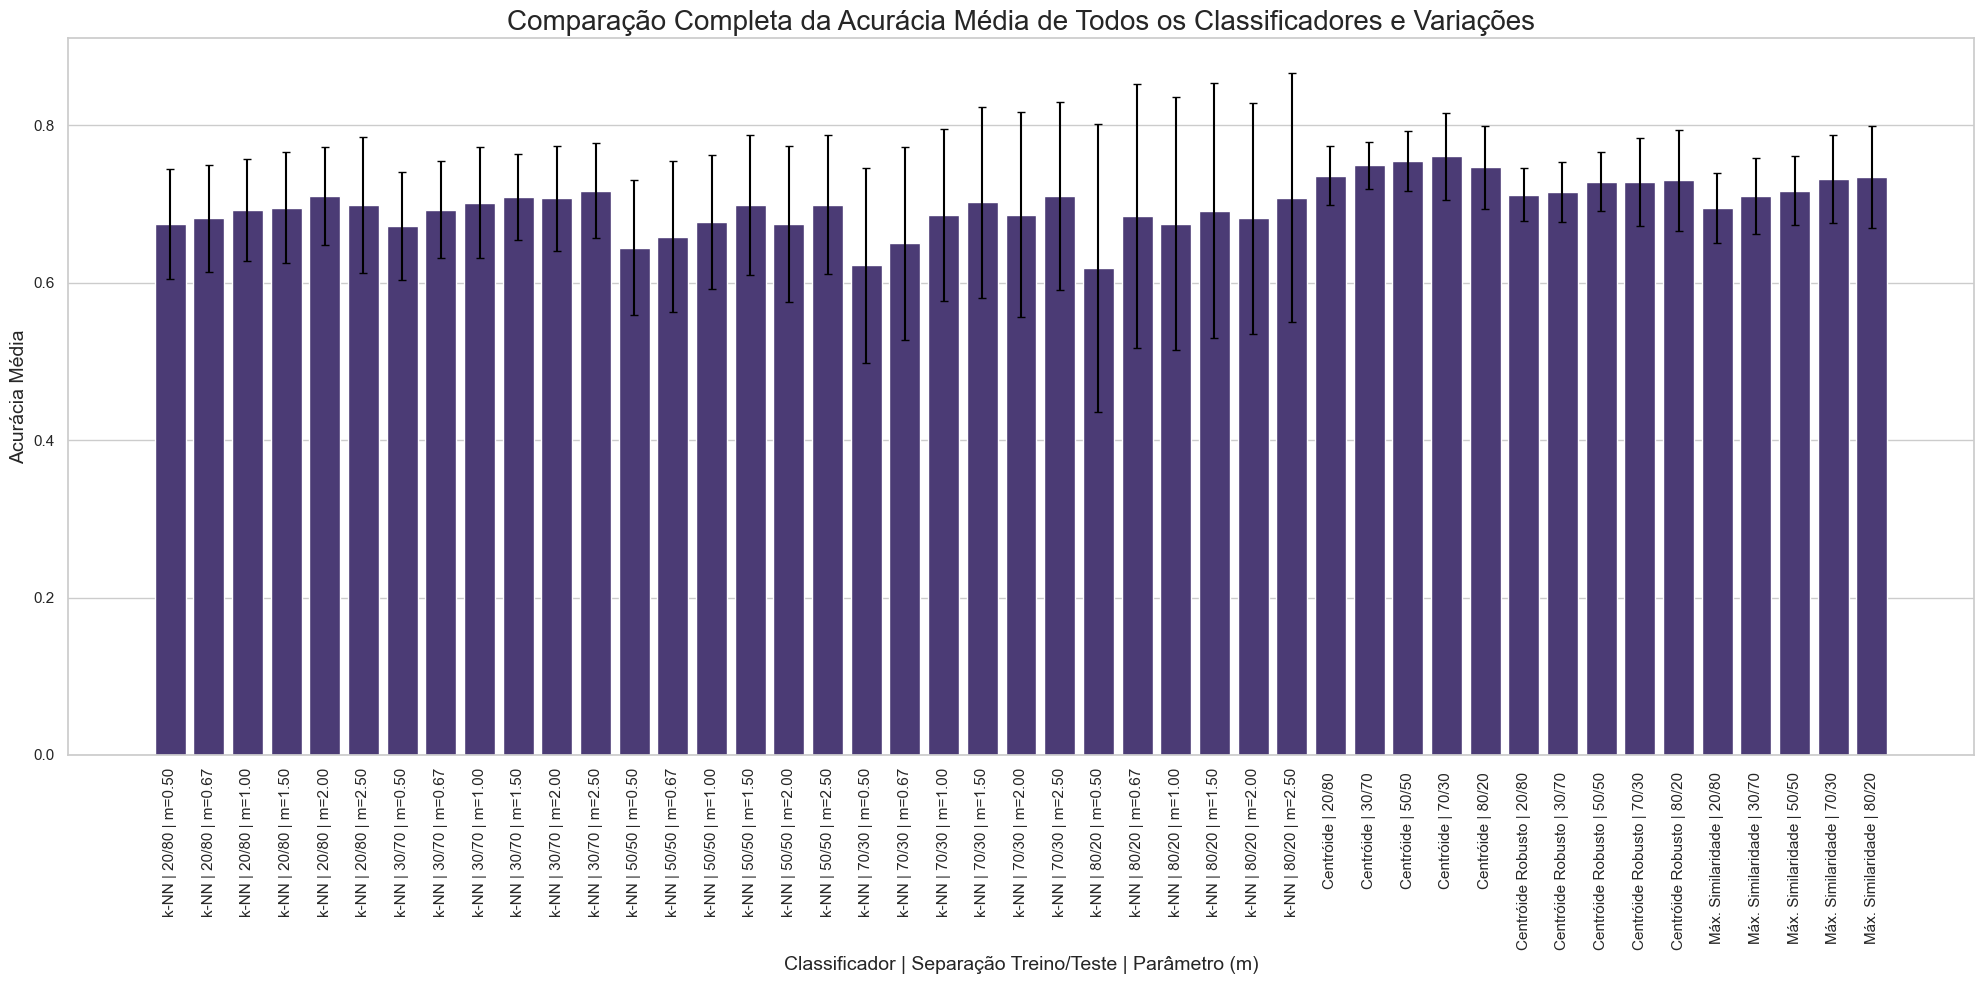

In [36]:
# 2. Geração do Gráfico de Barras Completo

# Ordena o DataFrame para o gráfico seguir a ordem dos experimentos
ordem_classificador = ['k-NN', 'Centróide', 'Centróide Robusto', 'Máx. Similaridade']
df_final['classificador'] = pd.Categorical(df_final['classificador'], categories=ordem_classificador, ordered=True)
df_ordenado = df_final.sort_values(['classificador', 'proporcao_treino', 'parametro_m'])

# Cria um rótulo único para cada barra para facilitar a visualização no gráfico
df_ordenado['rotulo'] = df_ordenado['classificador'].astype(str) + ' | ' + \
                        df_ordenado['separacao'].astype(str) + ' | m=' + \
                        df_ordenado['parametro_m'].astype(str)

# Ajusta rótulos para classificadores que não usam o parâmetro 'm'
df_ordenado['rotulo'] = df_ordenado['rotulo'].str.replace('\| m=N/A', '', regex=True)

# Configura o estilo do gráfico
sns.set_theme(style="whitegrid", palette="viridis")

# Plota o gráfico
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=df_ordenado, x='rotulo', y='media')

# Adiciona as barras de erro (desvio padrão)
plt.errorbar(x=df_ordenado['rotulo'], y=df_ordenado['media'],
             yerr=df_ordenado['desvio'], fmt='none', c='black', capsize=3)

plt.title('Comparação Completa da Acurácia Média de Todos os Classificadores e Variações', fontsize=20)
plt.xlabel('Classificador | Separação Treino/Teste | Parâmetro (m)', fontsize=14)
plt.ylabel('Acurácia Média', fontsize=14)

# Rotaciona os rótulos do eixo X para que não se sobreponham
plt.xticks(rotation=90)

# Ajusta o limite do eixo Y para dar mais destaque às diferenças de performance
min_media = df_ordenado['media'].min()
max_media = df_ordenado['media'].max()
#plt.ylim(min_media * 0.9, max_media * 1.05)

plt.tight_layout() # Garante que todos os elementos do gráfico fiquem visíveis
plt.show()

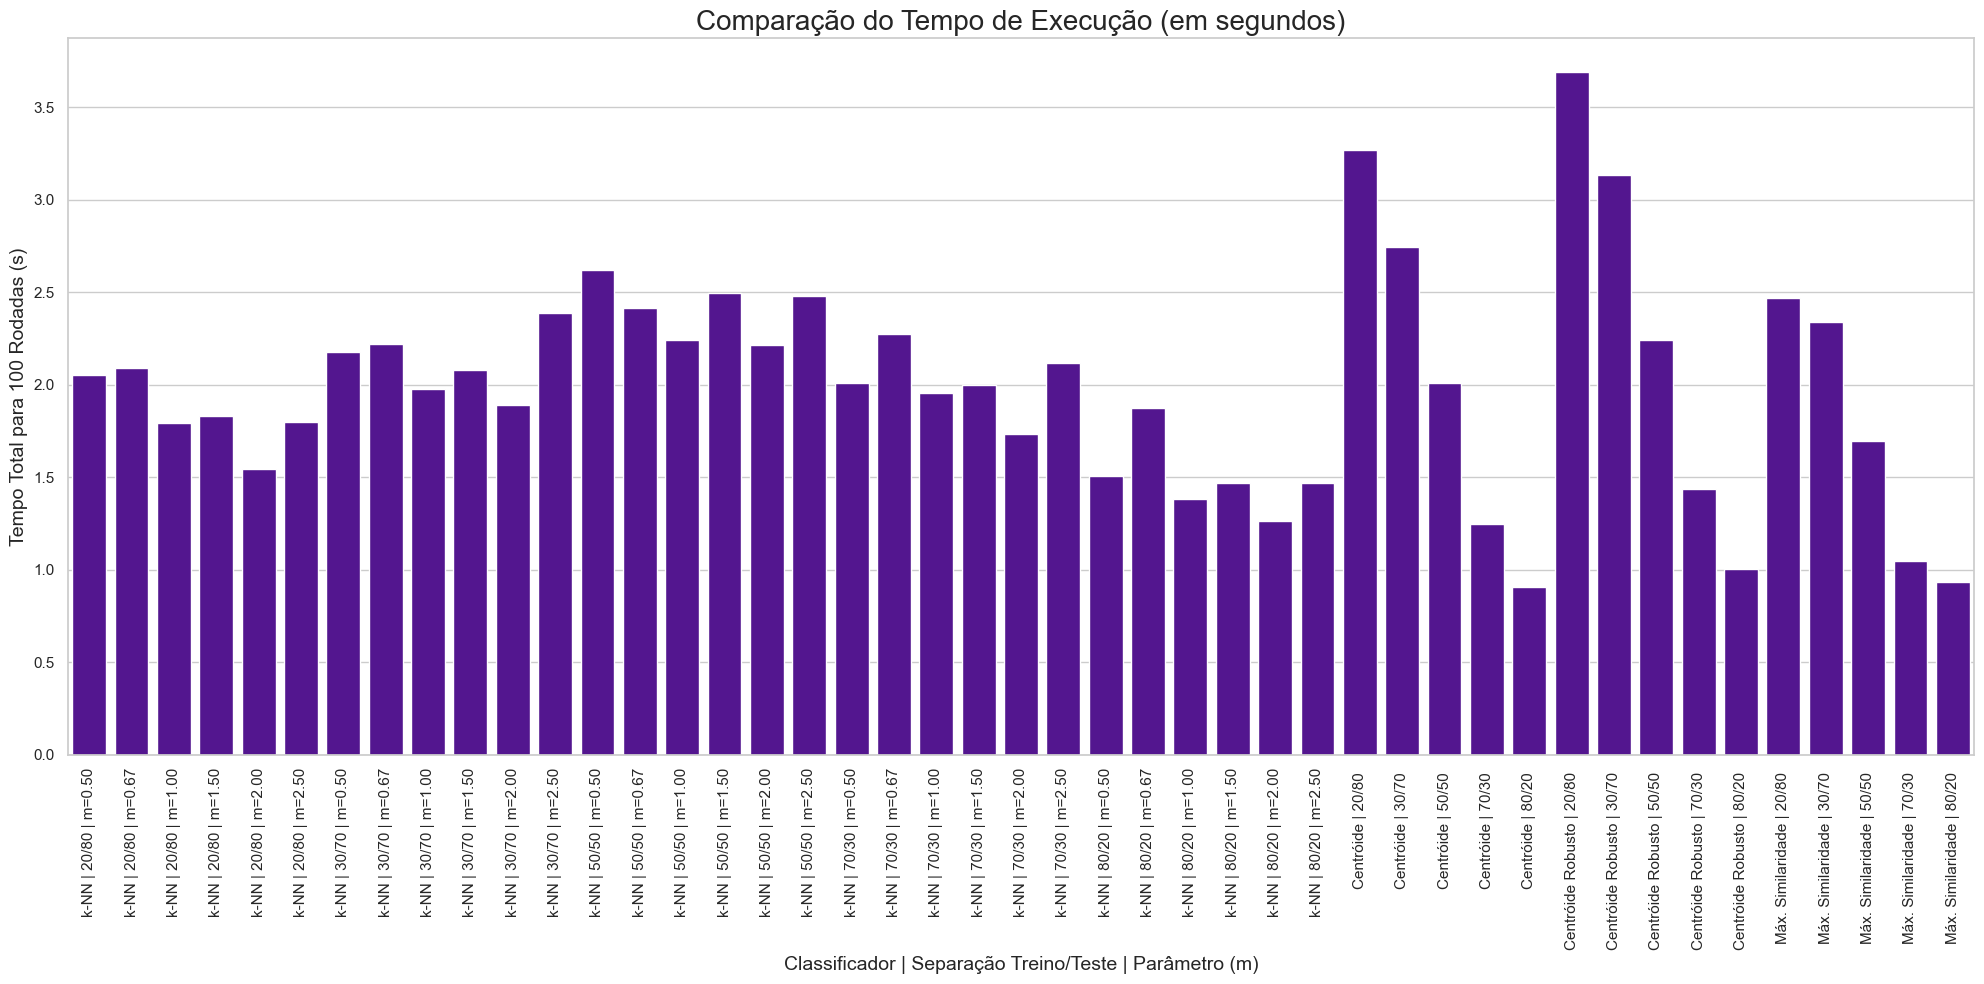

In [37]:
# Gráfico de Barras para o Tempo de Execução

# Configura o estilo do gráfico
sns.set_theme(style="whitegrid", palette="plasma")

# Plota o gráfico
plt.figure(figsize=(20, 10))
sns.barplot(data=df_ordenado, x='rotulo', y='tempo')

plt.title('Comparação do Tempo de Execução (em segundos)', fontsize=20)
plt.xlabel('Classificador | Separação Treino/Teste | Parâmetro (m)', fontsize=14)
plt.ylabel('Tempo Total para 100 Rodadas (s)', fontsize=14)

# Rotaciona os rótulos do eixo X para que não se sobreponham
plt.xticks(rotation=90)

plt.tight_layout() # Garante que todos os elementos do gráfico fiquem visíveis
plt.show()

In [38]:
# 4. Consolidação dos Dados POR CLASSE

dados_por_classe = []
# Pega as classes do seu primeiro resultado (ex: ['NO', 'SL', 'DH'])
C = list(resultados_knn['20/80'][0.5]['stats_por_classe'].keys()) 

# Processa o k-NN
for separacao, resultados_m in resultados_knn.items():
    for m, metricas in resultados_m.items():
        # Itera sobre cada classe (NO, SL, DH)
        for classe, class_stats in metricas['stats_por_classe'].items():
            dados_por_classe.append({
                'classificador': 'k-NN',
                'separacao': separacao,
                'proporcao_treino': int(separacao.split('/')[0]),
                'parametro_m': f'{m:.2f}',
                'classe': classe, # Nova coluna
                'media_classe': class_stats['media'], # Acurácia média da classe
                'desvio_classe': class_stats['desvio'] # Desvio padrão da classe
            })

# Função auxiliar para os outros classificadores
def processar_classificador_por_classe(nome_classificador, resultados_dict, lista_destino):
    for separacao, metricas in resultados_dict.items():
        for classe, class_stats in metricas['stats_por_classe'].items():
            lista_destino.append({
                'classificador': nome_classificador,
                'separacao': separacao,
                'proporcao_treino': int(separacao.split('/')[0]),
                'parametro_m': 'N/A',
                'classe': classe,
                'media_classe': class_stats['media'],
                'desvio_classe': class_stats['desvio']
            })

# Processa os outros
processar_classificador_por_classe('Centróide', resultados_centroide, dados_por_classe)
processar_classificador_por_classe('Centróide Robusto', resultados_centroide_robusto, dados_por_classe)
processar_classificador_por_classe('Máx. Similaridade', resultados_similaridade, dados_por_classe)

# Cria o DataFrame final para as classes
df_classes = pd.DataFrame(dados_por_classe)

# Cria o mesmo rótulo único de antes
ordem_classificador = ['k-NN', 'Centróide', 'Centróide Robusto', 'Máx. Similaridade']
df_classes['classificador'] = pd.Categorical(df_classes['classificador'], categories=ordem_classificador, ordered=True)
df_classes_ordenado = df_classes.sort_values(['classificador', 'proporcao_treino', 'parametro_m', 'classe'])

df_classes_ordenado['rotulo'] = df_classes_ordenado['classificador'].astype(str) + ' | ' + \
                                df_classes_ordenado['separacao'].astype(str) + ' | m=' + \
                                df_classes_ordenado['parametro_m'].astype(str)
df_classes_ordenado['rotulo'] = df_classes_ordenado['rotulo'].str.replace('\\| m=N/A', '', regex=True)

# print(df_classes_ordenado.head()) # Descomente para verificar

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\2013782877.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\2013782877.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\2013782877.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\2013782877.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


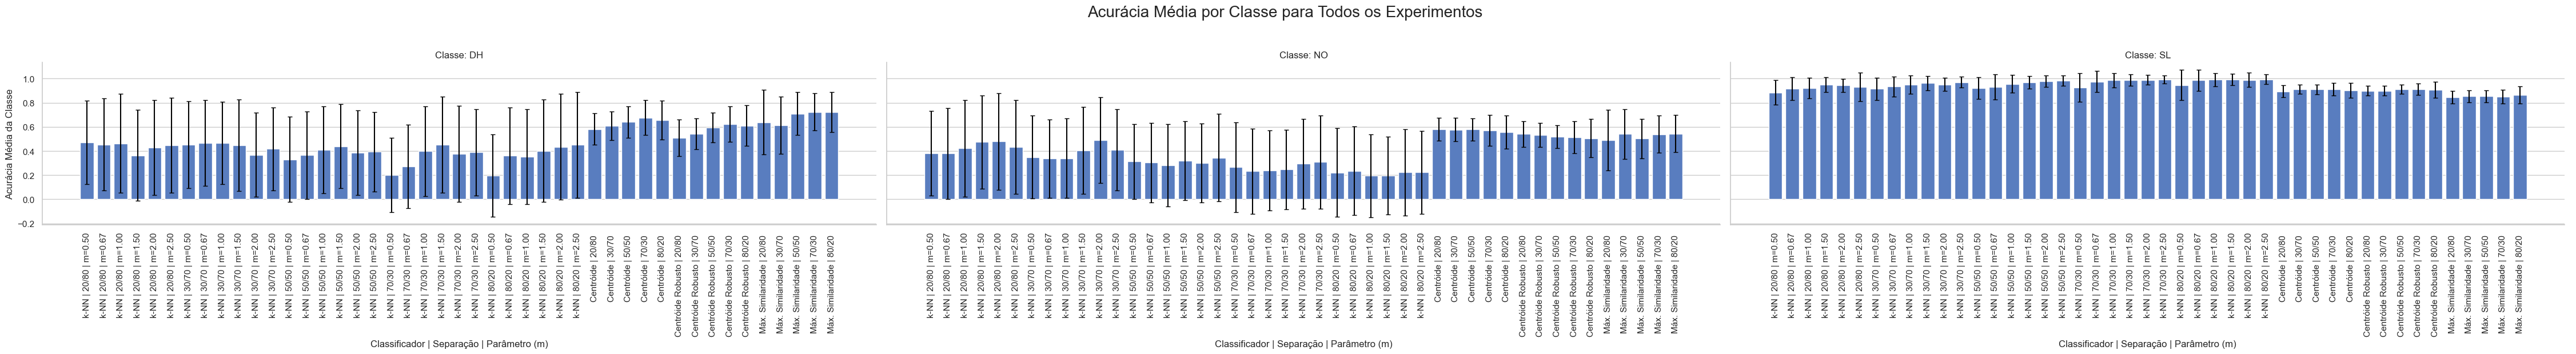

In [39]:
# 5. Geração do Gráfico de Barras (Acurácia POR CLASSE)

sns.set_theme(style="whitegrid", palette="muted")

# Cria um FacetGrid: gráficos separados por 'classe'
g = sns.catplot(
    data=df_classes_ordenado,
    x='rotulo',
    y='media_classe',
    col='classe',         # <-- Cria um subplot para cada classe
    kind='bar',
    height=6,             # Altura de CADA subplot
    aspect=2.5,           # Proporção largura/altura de CADA subplot
    ci=None               # Desliga a barra de erro padrão do catplot
)

# Adiciona as barras de erro manualmente (mais complexo no catplot)
# Iteramos sobre cada subplot (eixo)
for i, ax in enumerate(g.axes.flat):
    # Pega o nome da classe deste subplot
    classe_nome = g.col_names[i]
    # Filtra o DataFrame SÓ para esta classe
    df_subset = df_classes_ordenado[df_classes_ordenado['classe'] == classe_nome]
    
    # Plota a barra de erro para este subplot
    ax.errorbar(
        x=df_subset['rotulo'], 
        y=df_subset['media_classe'],
        yerr=df_subset['desvio_classe'], 
        fmt='none', 
        c='black', 
        capsize=3
    )
    
    # Gira os labels em cada subplot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("Classificador | Separação | Parâmetro (m)")

# Adiciona títulos
g.fig.suptitle('Acurácia Média por Classe para Todos os Experimentos', y=1.03, fontsize=20)
g.set_ylabels('Acurácia Média da Classe')
g.set_titles("Classe: {col_name}") # Título de cada subplot

plt.tight_layout()
plt.savefig('grafico_acuracia_por_classe.png') # Salva a figura
# plt.show() # Removido

In [40]:
# 1. Consolidação dos Dados em um único DataFrame

# Lista para armazenar todos os resultados globais
dados_grafico = []
# Lista para armazenar os resultados por classe
dados_por_classe = []

# Pega as classes (ex: 'NO', 'SL', 'DH')
C = list(resultados_knn['20/80'][0.5]['stats_por_classe'].keys())
ordem_separacao = list(sep.keys()) # ['20/80', '30/70', ...]

# --- Processa os resultados do k-NN ---
for separacao, resultados_m in resultados_knn.items():
    for m, metricas in resultados_m.items():
        rotulo_m = f'{m:.2f}'
        # Adiciona dados globais
        dados_grafico.append({
            'classificador': 'k-NN',
            'separacao': separacao,
            'proporcao_treino': int(separacao.split('/')[0]),
            'parametro_m': rotulo_m,
            'rotulo_curto': f'k-NN (m={rotulo_m})', # Novo rótulo
            'media': metricas.get('media', metricas.get('media_global')), # Pega 'media' ou 'media_global'
            'desvio': metricas.get('desvio', metricas.get('desvio_global')),
            'tempo': metricas['tempo']
        })
        # Adiciona dados por classe
        for classe, class_stats in metricas['stats_por_classe'].items():
            dados_por_classe.append({
                'classificador': 'k-NN',
                'separacao': separacao,
                'proporcao_treino': int(separacao.split('/')[0]),
                'parametro_m': rotulo_m,
                'rotulo_curto': f'k-NN (m={rotulo_m})',
                'classe': classe,
                'media_classe': class_stats['media'],
                'desvio_classe': class_stats['desvio']
            })

# --- Função auxiliar para os outros classificadores ---
def processar_classificador(nome_classificador, resultados_dict, lista_global, lista_classe):
    for separacao, metricas in resultados_dict.items():
        # Adiciona dados globais
        lista_global.append({
            'classificador': nome_classificador,
            'separacao': separacao,
            'proporcao_treino': int(separacao.split('/')[0]),
            'parametro_m': 'N/A',
            'rotulo_curto': nome_classificador,
            'media': metricas.get('media', metricas.get('media_global')),
            'desvio': metricas.get('desvio', metricas.get('desvio_global')),
            'tempo': metricas['tempo']
        })
        # Adiciona dados por classe
        for classe, class_stats in metricas['stats_por_classe'].items():
            lista_classe.append({
                'classificador': nome_classificador,
                'separacao': separacao,
                'proporcao_treino': int(separacao.split('/')[0]),
                'parametro_m': 'N/A',
                'rotulo_curto': nome_classificador,
                'classe': classe,
                'media_classe': class_stats['media'],
                'desvio_classe': class_stats['desvio']
            })

# Processa os outros
processar_classificador('Centróide', resultados_centroide, dados_grafico, dados_por_classe)
processar_classificador('Centróide Robusto', resultados_centroide_robusto, dados_grafico, dados_por_classe)
processar_classificador('Máx. Similaridade', resultados_similaridade, dados_grafico, dados_por_classe)

# --- Cria os DataFrames Finais e Ordena ---
df_final = pd.DataFrame(dados_grafico)
df_classes = pd.DataFrame(dados_por_classe)

# Define a ordem correta dos classificadores e rótulos
ordem_classificador = ['k-NN', 'Centróide', 'Centróide Robusto', 'Máx. Similaridade']
# Gera a ordem dos rótulos curtos
ordem_rotulos = []
for classif in ordem_classificador:
    if classif == 'k-NN':
        for m in [0.5, 2/3, 1, 3/2, 2, 5/2]:
            ordem_rotulos.append(f'k-NN (m={m:.2f})')
    else:
        ordem_rotulos.append(classif)

# Aplica a ordem categórica aos DataFrames
df_final['rotulo_curto'] = pd.Categorical(df_final['rotulo_curto'], categories=ordem_rotulos, ordered=True)
df_classes['rotulo_curto'] = pd.Categorical(df_classes['rotulo_curto'], categories=ordem_rotulos, ordered=True)
df_final['separacao'] = pd.Categorical(df_final['separacao'], categories=ordem_separacao, ordered=True)
df_classes['separacao'] = pd.Categorical(df_classes['separacao'], categories=ordem_separacao, ordered=True)

# Ordena os valores
df_final_ordenado = df_final.sort_values(['separacao', 'rotulo_curto'])
df_classes_ordenado = df_classes.sort_values(['separacao', 'rotulo_curto', 'classe'])

C_ordenado = sorted(list(df_classes_ordenado['classe'].unique())) # Ordem das classes, ex: ['DH', 'NO', 'SL']

print("DataFrames prontos para plotagem.")
#print(df_final_ordenado.head())
#print(df_classes_ordenado.head())

DataFrames prontos para plotagem.


C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')


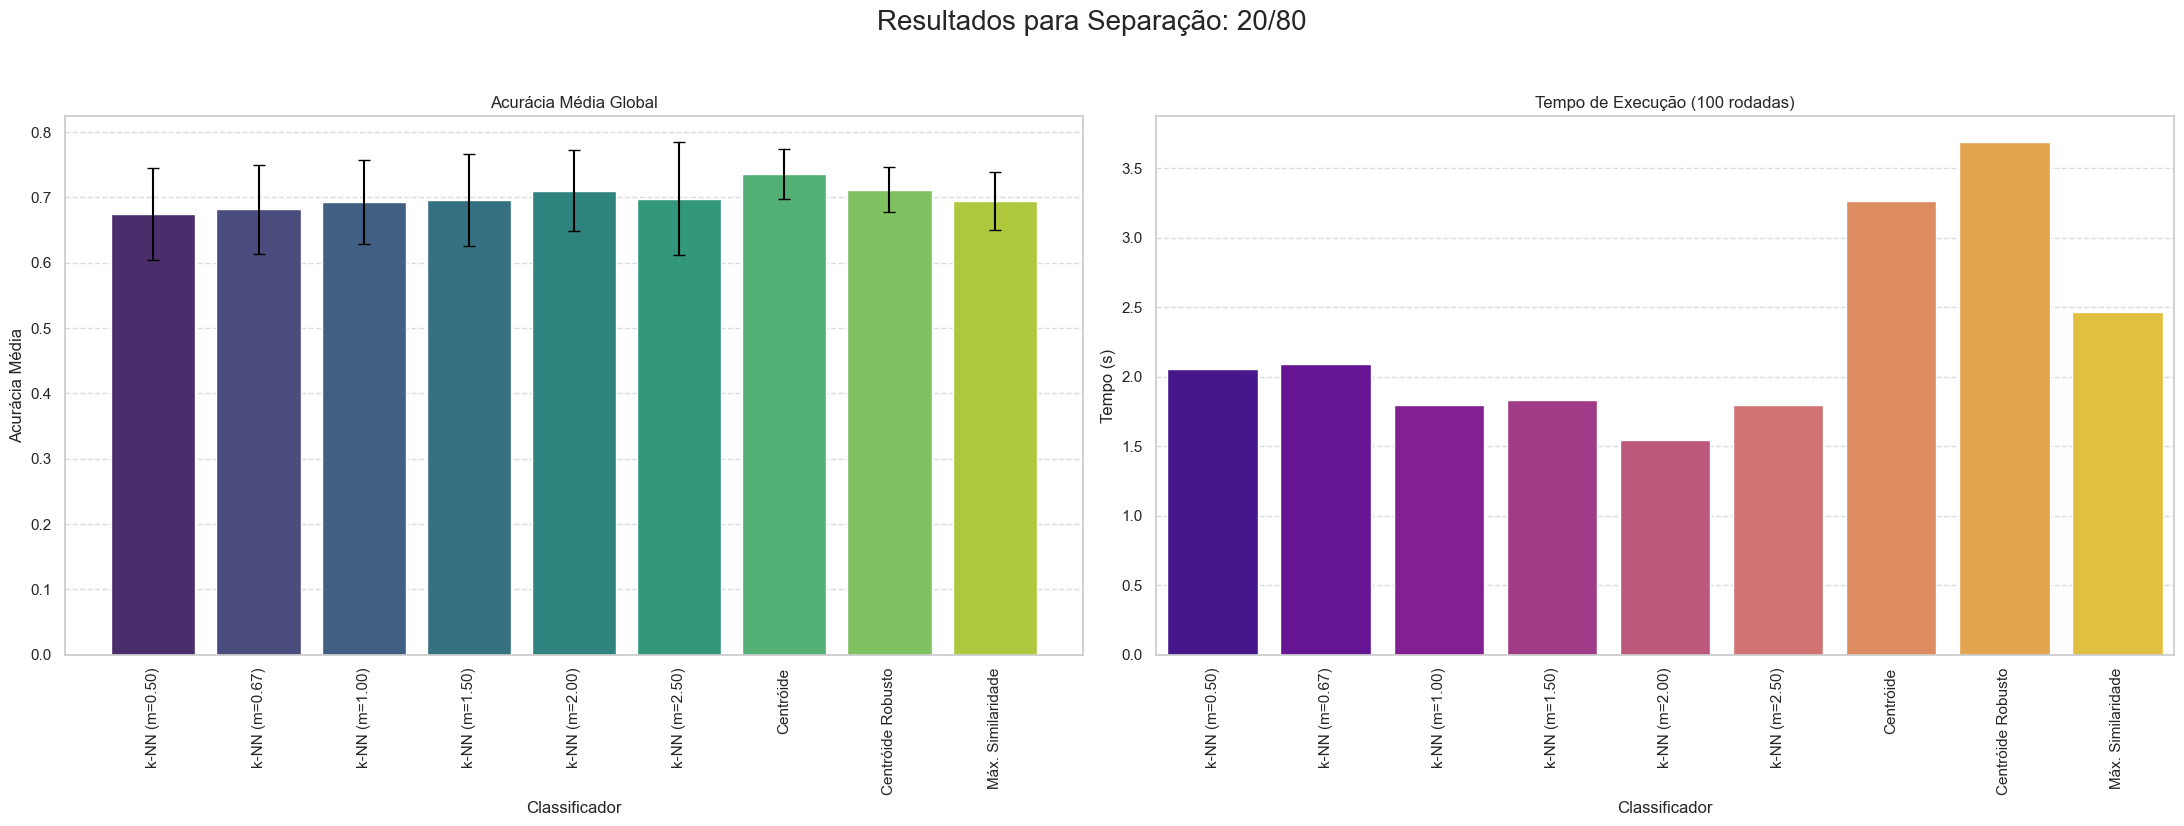

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning

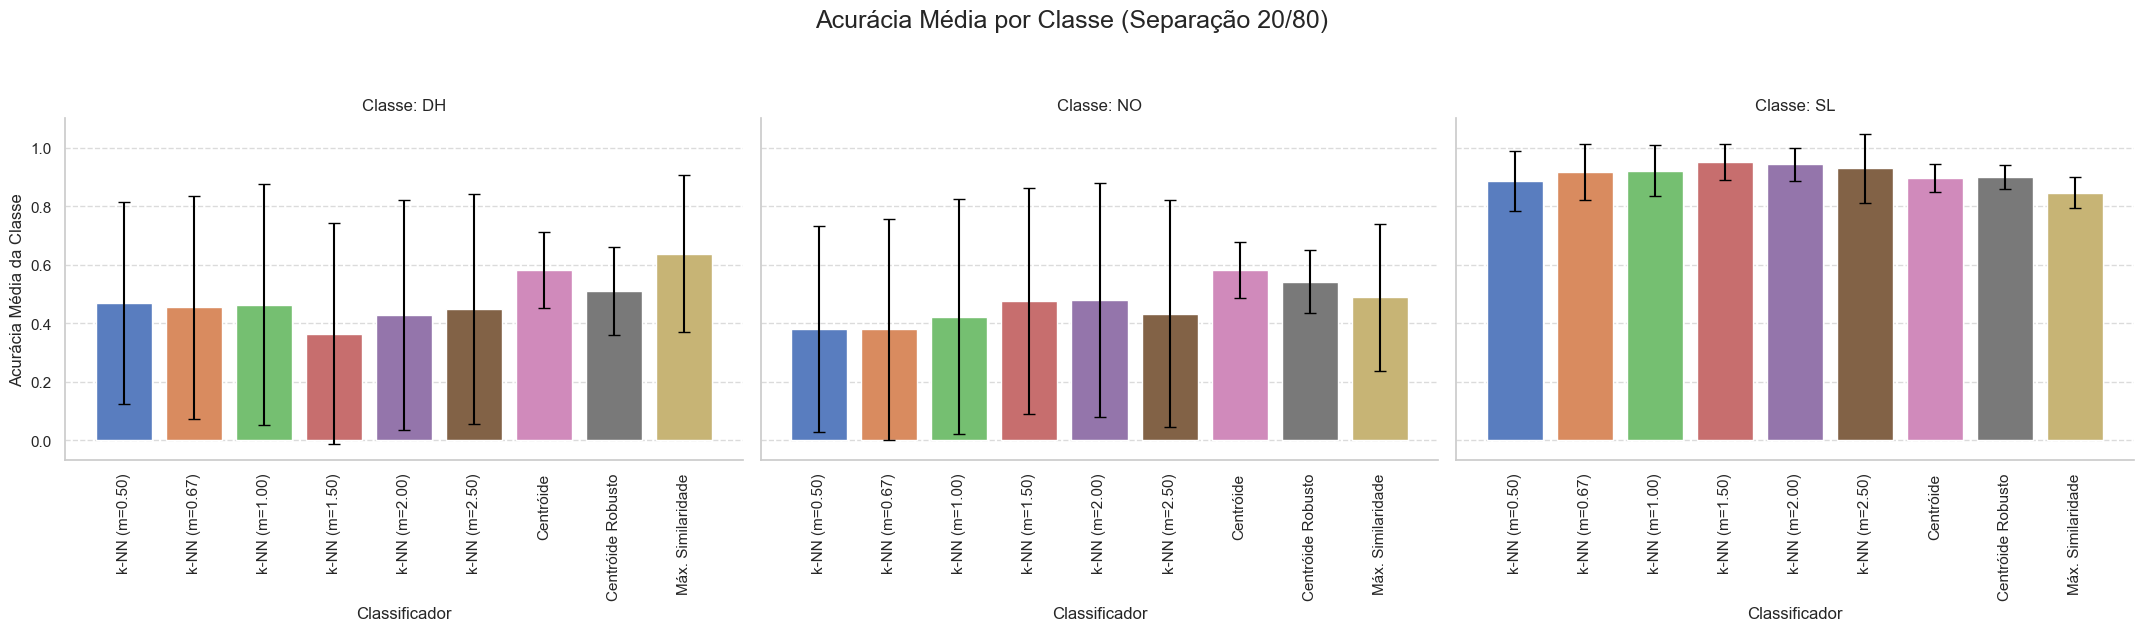

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')


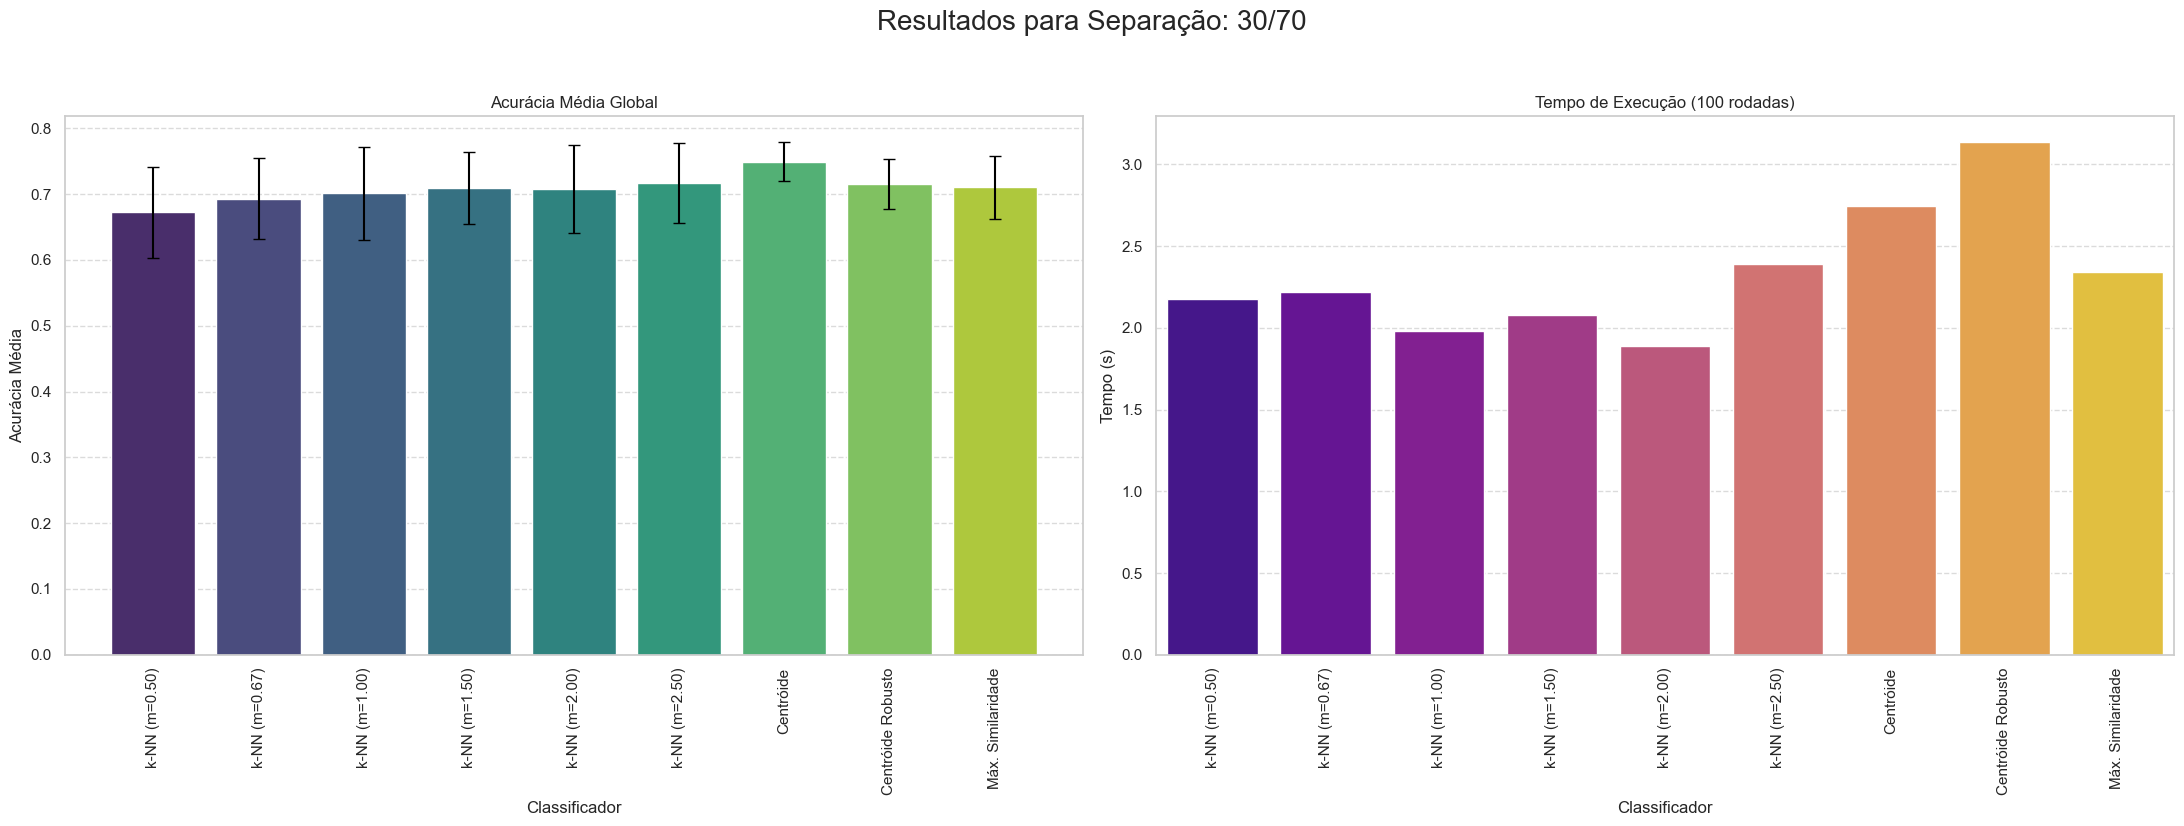

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning

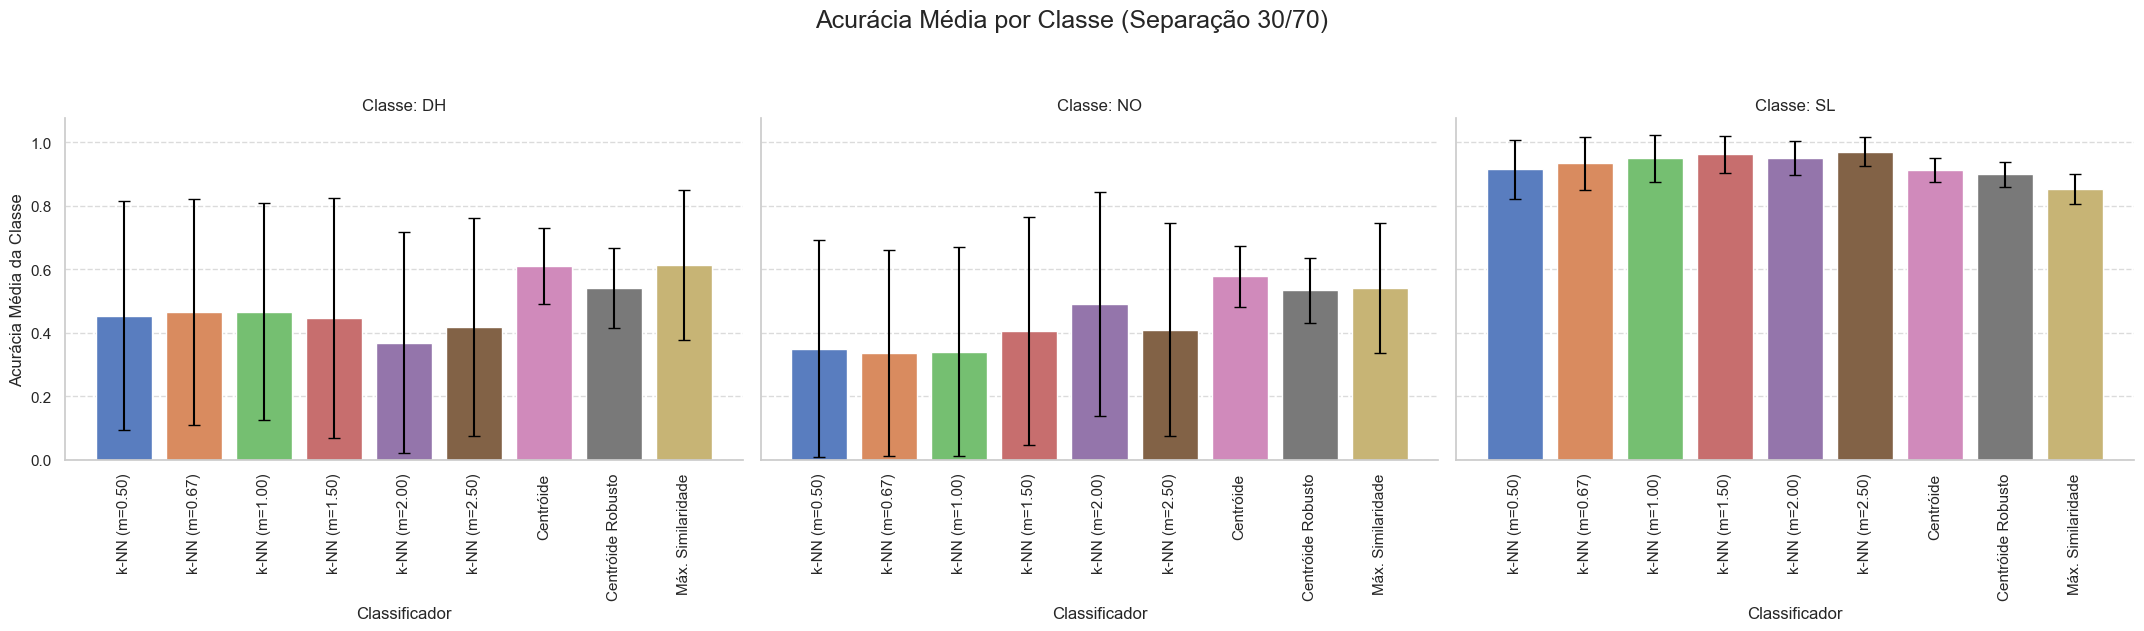

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')


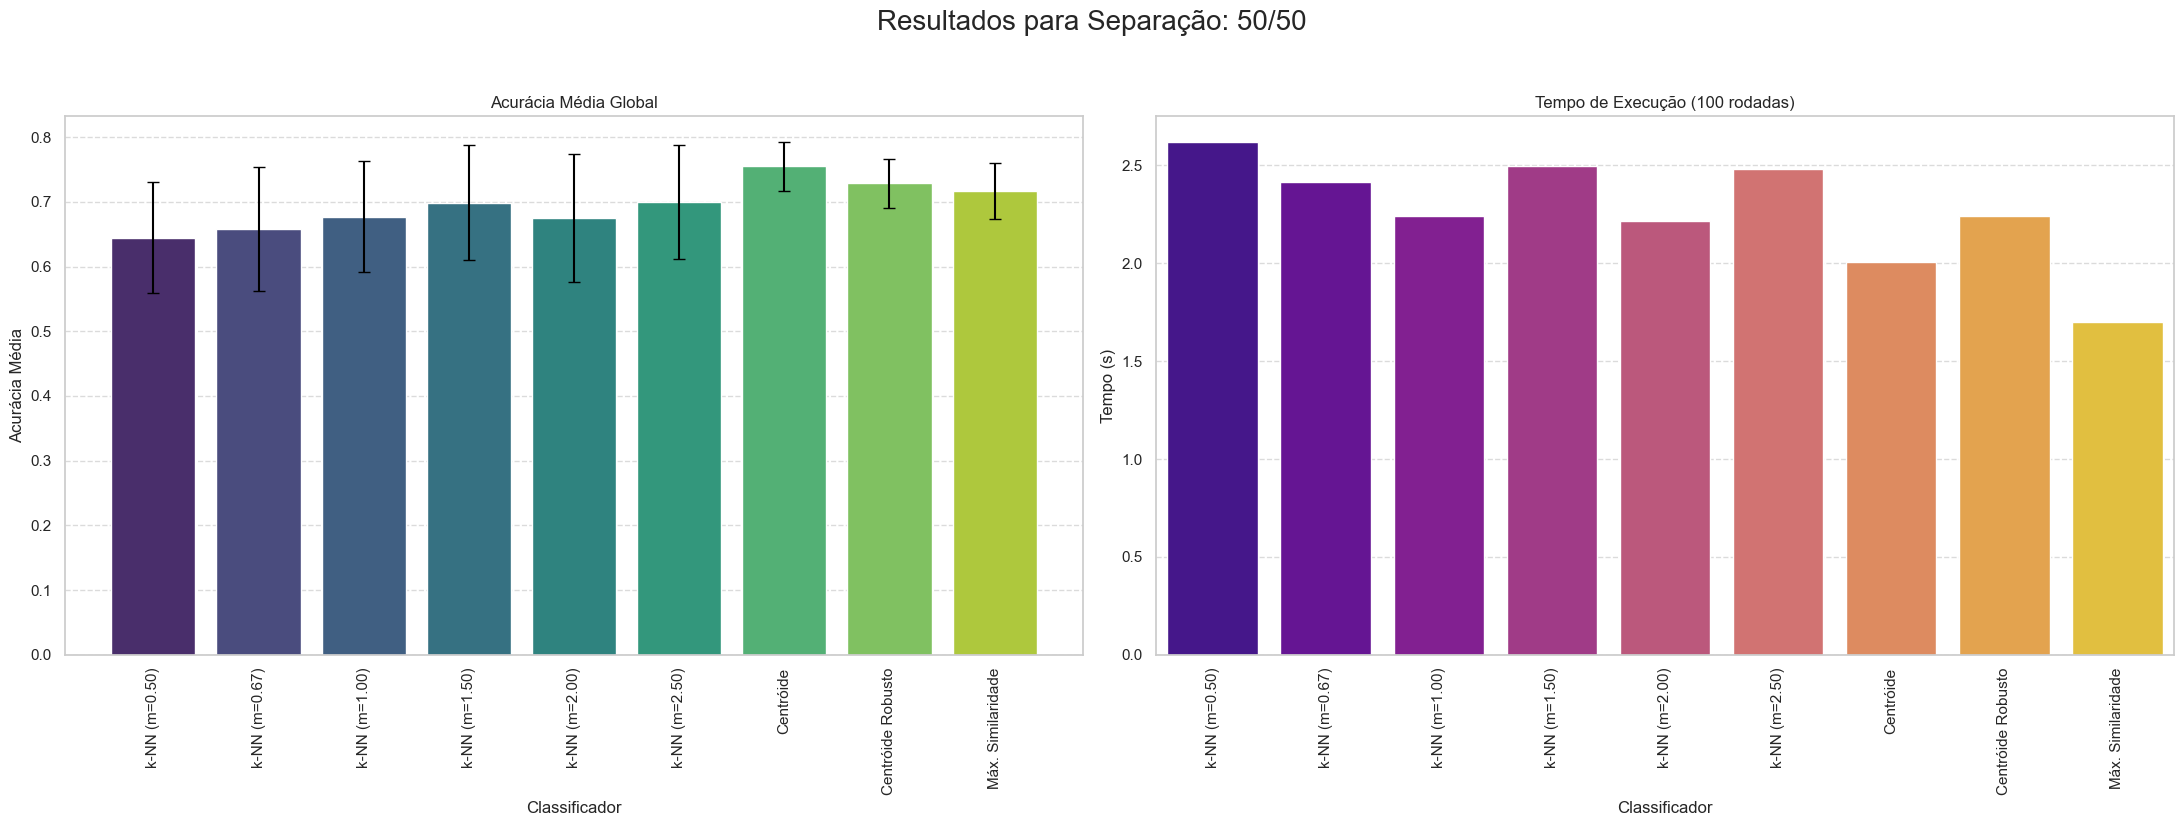

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning

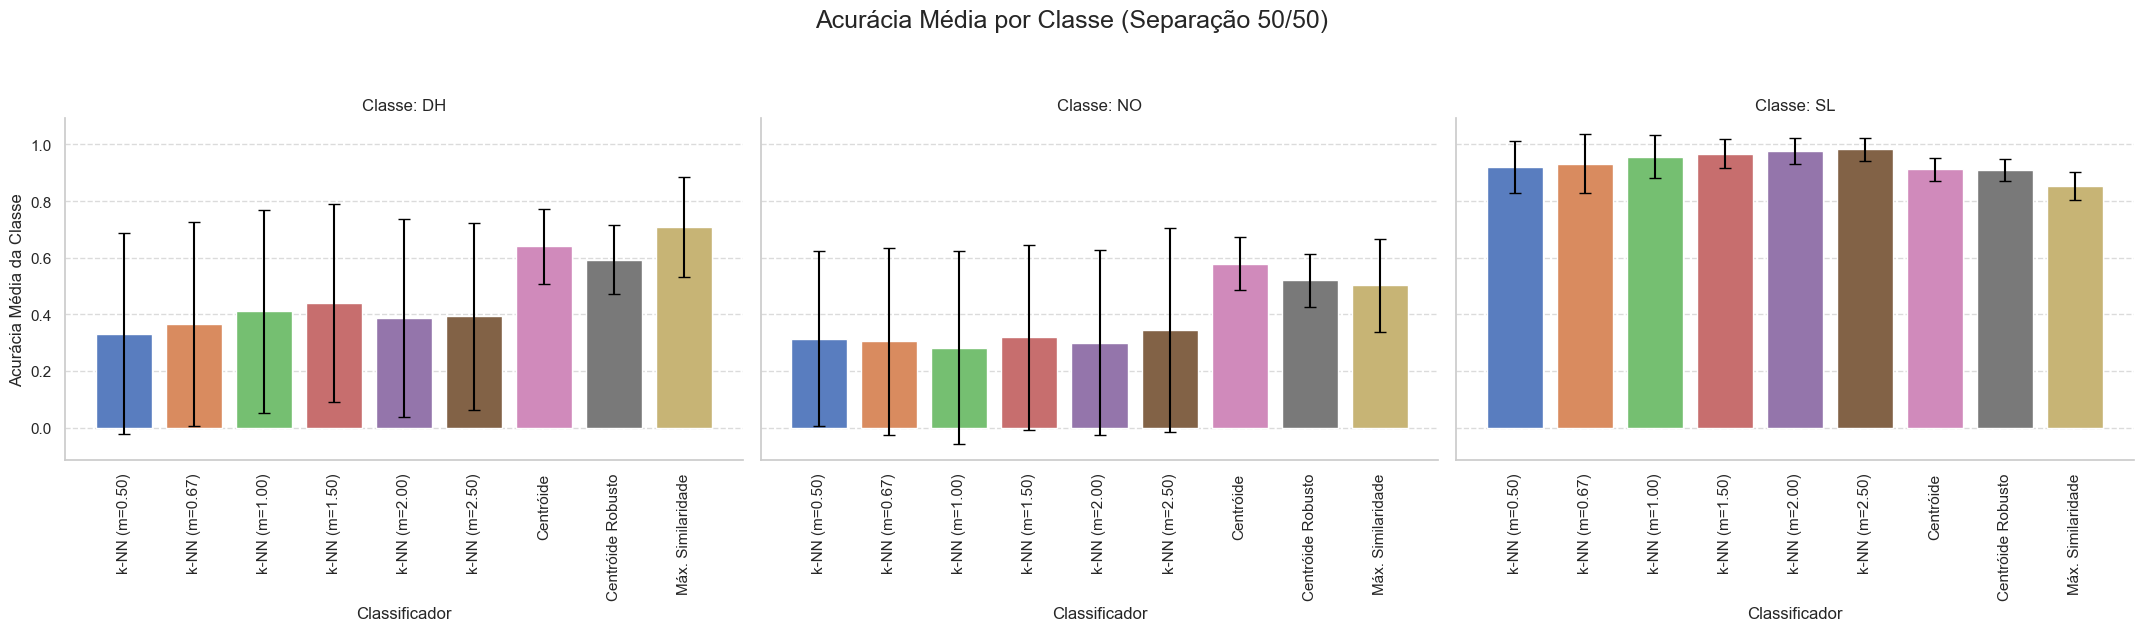

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')


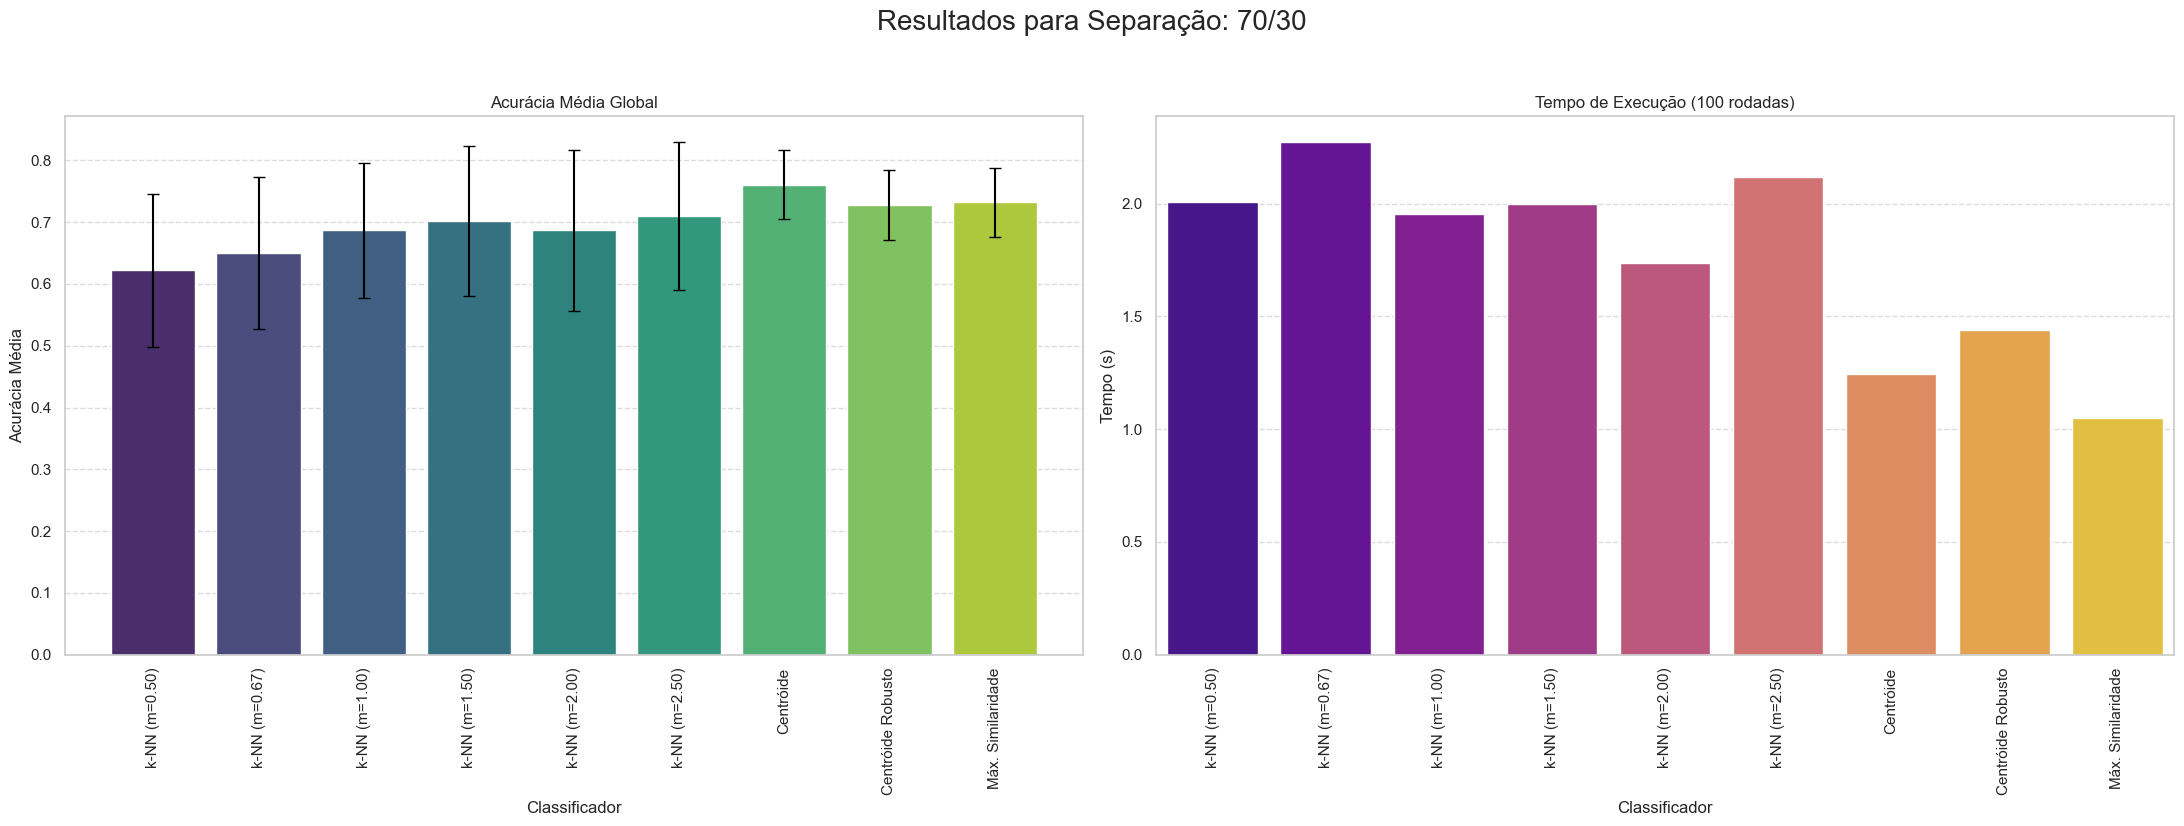

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning

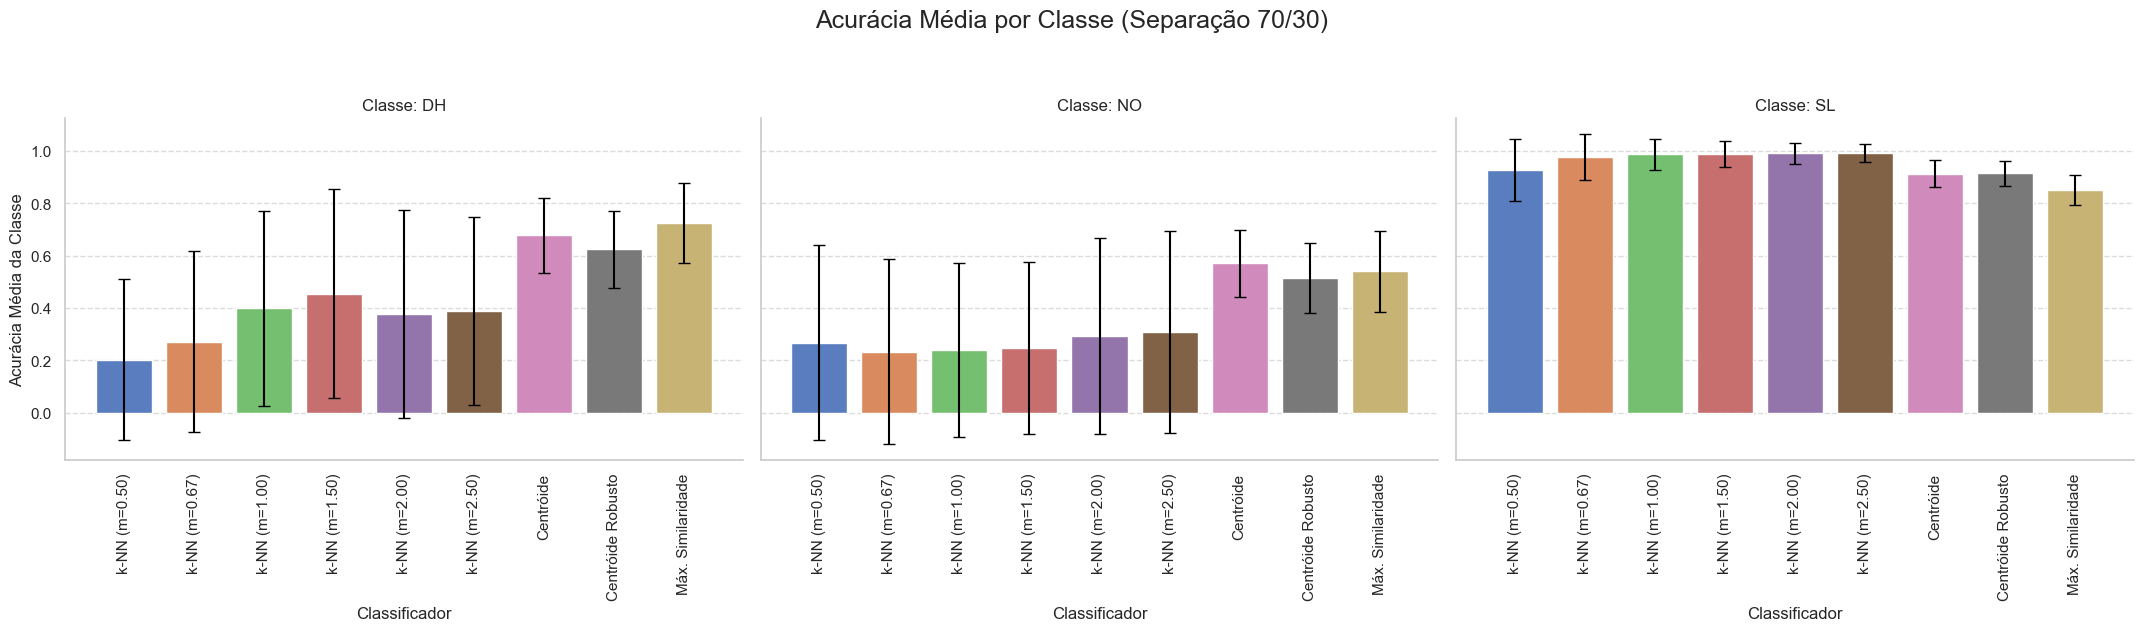

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')


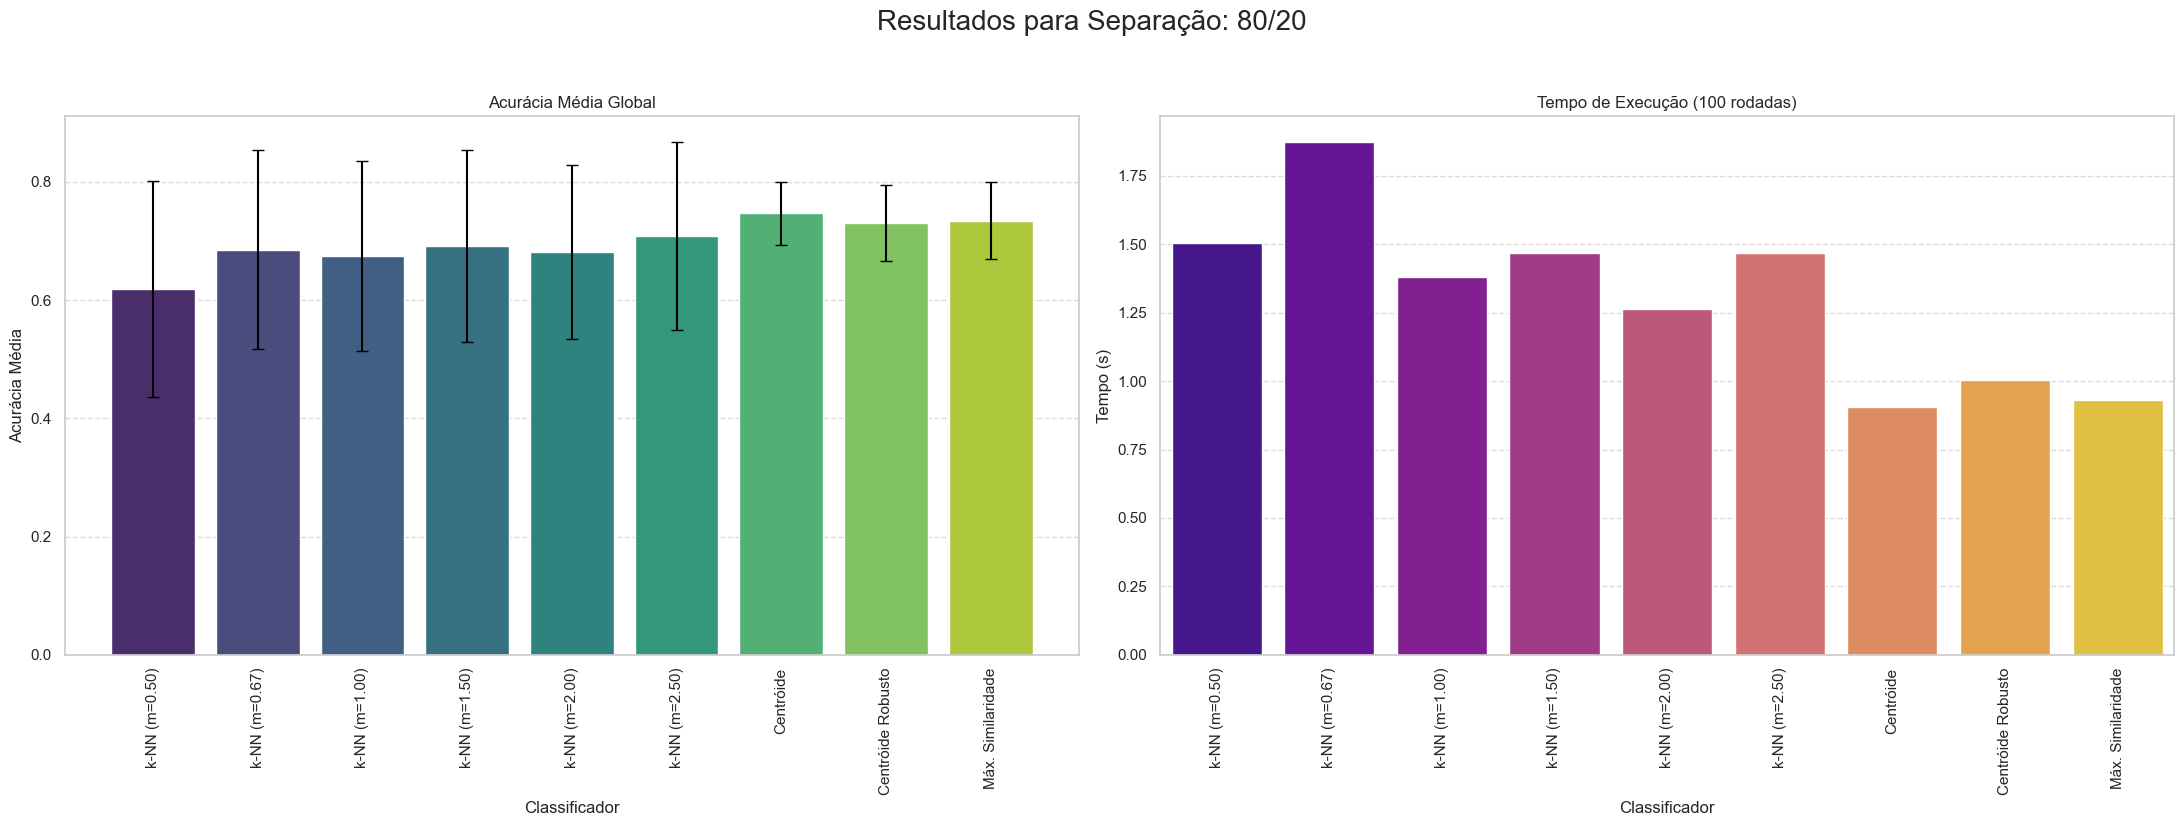

C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\luisx\AppData\Local\Temp\ipykernel_41556\650802869.py:72: SettingWithCopyWarning

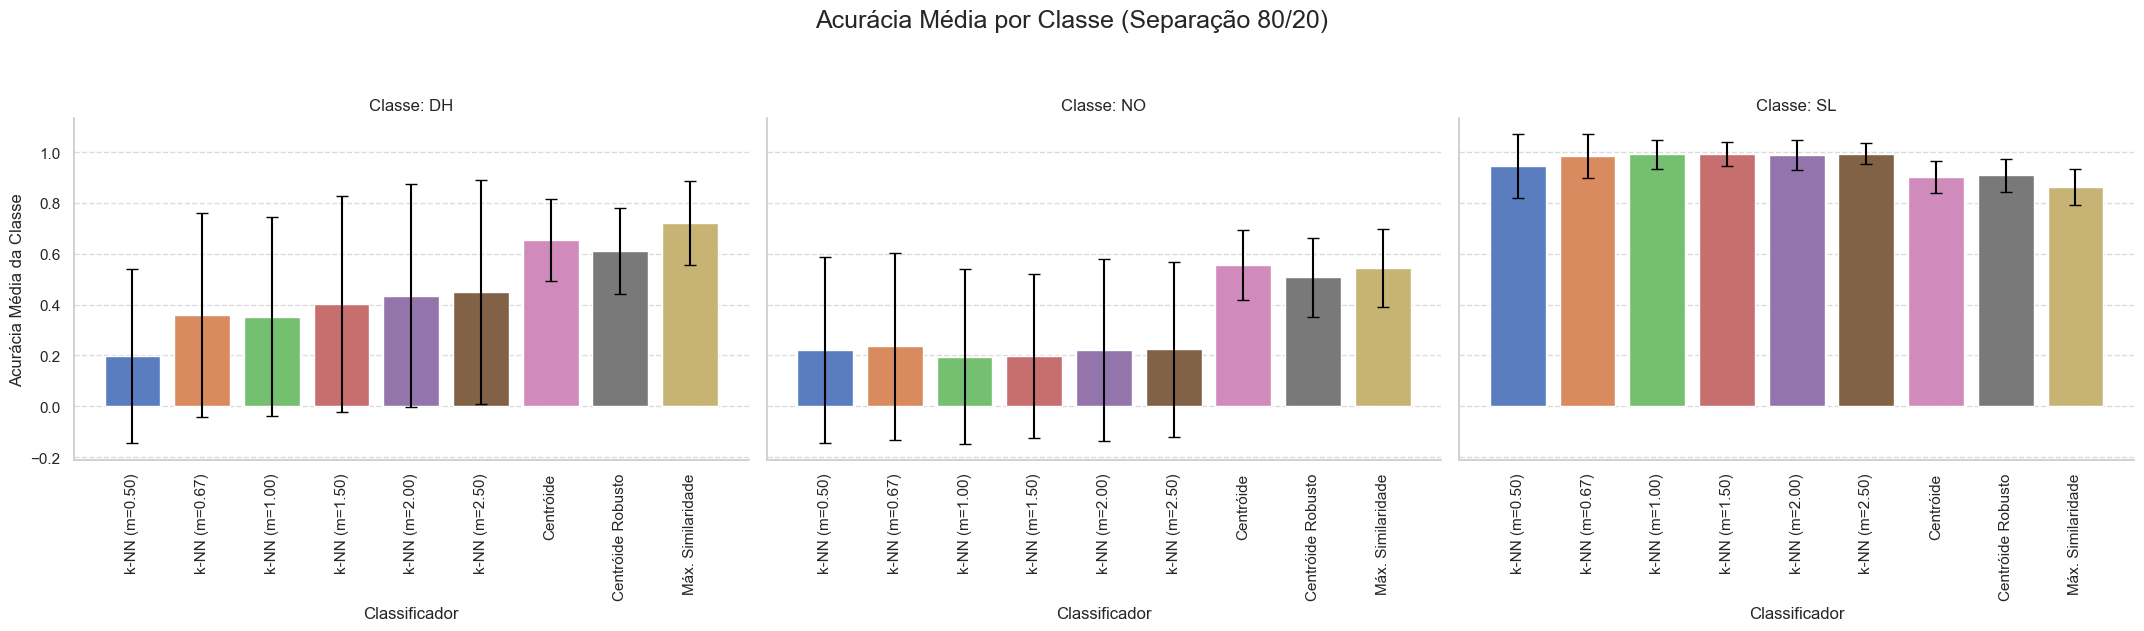

In [41]:
import warnings
# Suprime avisos do seaborn sobre não poder usar 'hue' com 'errorbar' (já estamos fazendo manualmente)
warnings.filterwarnings('ignore', category=UserWarning)

# Itera sobre cada separação
for s in ordem_separacao:
    
    # --- Filtra os dados apenas para esta separação ---
    df_g_s = df_final_ordenado[df_final_ordenado['separacao'] == s].copy()
    df_c_s = df_classes_ordenado[df_classes_ordenado['separacao'] == s].copy()
    
    # Pega a ordem dos rótulos para o eixo X
    rotulos_x = df_g_s['rotulo_curto'].unique()

    # ======================================================================
    # GRÁFICO 1: Acurácia Global e Tempo (lado a lado)
    # ======================================================================
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8)) # 1 linha, 2 colunas
    fig.suptitle(f'Resultados para Separação: {s}', fontsize=20, y=1.03)

    # --- Plot 1.1: Acurácia Global ---
    sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
    # Adiciona barras de erro (desvio padrão)
    ax1.errorbar(x=rotulos_x, y=df_g_s['media'], yerr=df_g_s['desvio'], fmt='none', c='black', capsize=4)
    ax1.set_title('Acurácia Média Global')
    ax1.set_ylabel('Acurácia Média')
    ax1.set_xlabel('Classificador')
    ax1.set_xticklabels(rotulos_x, rotation=90)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Plot 1.2: Tempo ---
    sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')
    ax2.set_title('Tempo de Execução (100 rodadas)')
    ax2.set_ylabel('Tempo (s)')
    ax2.set_xlabel('Classificador')
    ax2.set_xticklabels(rotulos_x, rotation=90)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'grafico_global_tempo_{s.replace("/", "-")}.png')
    plt.show()

    # ======================================================================
    # GRÁFICO 2: Acurácia por Classe (sub-plots)
    # ======================================================================
    
    # Usamos catplot para criar subplots (colunas) para cada classe
    g = sns.catplot(
        data=df_c_s, 
        x='rotulo_curto', 
        y='media_classe', 
        col='classe',         # Cria um subplot para cada classe
        col_order=C_ordenado, # Garante a ordem (DH, NO, SL)
        kind='bar', 
        ci=None,              # Desligamos a barra de erro padrão
        height=6,             # Altura de cada subplot
        aspect=1.2,           # Proporção (largura/altura)
        order=rotulos_x,      # Garante a mesma ordem de barras
        palette='muted'
    )
    
    g.fig.suptitle(f'Acurácia Média por Classe (Separação {s})', y=1.05, fontsize=18)

    # Adiciona as barras de erro (desvio padrão) manualmente
    for i, ax in enumerate(g.axes.flat):
        classe_nome = g.col_names[i] # Pega o nome da classe (ex: 'DH')
        
        # Filtra o DataFrame de classes para esta classe e separação
        df_subset = df_c_s[df_c_s['classe'] == classe_nome]
        
        # Garante que os dados do subset estejam na ordem correta
        df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
        df_subset = df_subset.sort_values('rotulo_curto')
        
        # Plota a barra de erro
        ax.errorbar(
            x=df_subset['rotulo_curto'], 
            y=df_subset['media_classe'],
            yerr=df_subset['desvio_classe'], 
            fmt='none', 
            c='black', 
            capsize=4
        )
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylabel('Acurácia Média da Classe')
        ax.set_xlabel('Classificador')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    g.set_titles("Classe: {col_name}") # Título de cada subplot
    plt.tight_layout()
    plt.savefig(f'grafico_por_classe_{s.replace("/", "-")}.png')
    plt.show()